# Time Series Modeling in Python
## Part 1: Research Question
This analysis will use an ARIMA time series model in Python to allow forecasting of upcoming revenue for the telecom company. This model will be fit on data that shows the revenue per day of the company for the last two years since the companies inception. The goal will be to produce a model that will accurately answer the questions: what are the predicted revenues for the next month? A month will be assumed to be 30 days for the purpose of this analysis.

## Part 2: Method Justification 
Time series models are useful for projection values that are tracked on a time scale, such as revenue. Time Series models have the assumption that the data being fed to them is stationary, that is, they do not show trends and have a constant variance. Transformations, such as differencing, are often needed before the data can be considered stationary. Time Series models also assume that the values have some degree of autocorrelation. This means the current value is somehow correlated to a value that occured before it. 


#### Data Sources
- teleco_time_series.csv: WGU task prompt

#### Package Imports

In [1]:
# Data Manipulation and Handling
import numpy as np
import pandas as pd

# Time Series Metrics and Plots
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as mse
from scipy.signal import welch

# Model Building
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

## Part 3: Data Preparation

In [2]:
# Load time series data into a dataframe and set 'Day' as the index
df = pd.read_csv('teleco_time_series.csv', index_col='Day', parse_dates=True)
df.index = pd.to_datetime(df.index, origin='2018', unit='d')

# Revenue is in millions, multiply by one million to have real value in datafram
df['Revenue'] = df['Revenue']*1000000

df.to_csv('time_series_clean.csv')

print(df.shape)
print(df.isnull().sum())

(731, 1)
Revenue    0
dtype: int64


The data frame has no null values and is ready to plot.

#### 1. Provide a line graph visualizing the realization of the time series.

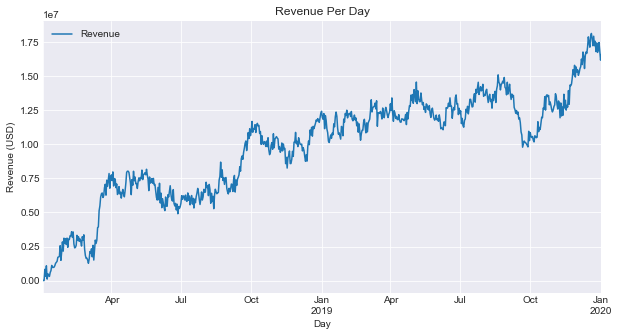

In [3]:
# Plot data to assess if it is a time series
df.plot(figsize=(10, 5))
plt.title('Revenue Per Day')
plt.ylabel('Revenue (USD)')
plt.show()

#### 2. Describe the time step formatting of the realization, including any gaps in measurement and the length of the sequence.
It is clear from the plot above that the dataset is a time series. The data shows the revenue per unit time and in this case the time step is in days. Above we checked for null values and there were none so we know there are no gaps in the data set. The data represents the first two years of sales for the telecom company and has 761 observations in the sequence.

#### 3. Evaluate the stationarity of the time series.
The plot above shows the raw data is not stationary. That is, it shows a clear trend and does not have constant variance over time. Below we will test the stationarity with an Augmented Dickey-Fuller test which has a null hypothesis that the data is not stationary. 

In [4]:
# Run an Augmented Dickey-Fuller Test to check for stationarity
result = adfuller(df['Revenue'])

print('Augmented Dickey-Fuller p-value: %.3f'%result[1])

Augmented Dickey-Fuller p-value: 0.321


The p-value leads us to fail to reject the null hypothesis and conclude that the data is not stationary. This paired with plot showing the data as non-stationary means we will need to transform the data before being able to model it.

##### Transforming the Data
We will first check to see if lag-1 differencing of the data will make it stationary

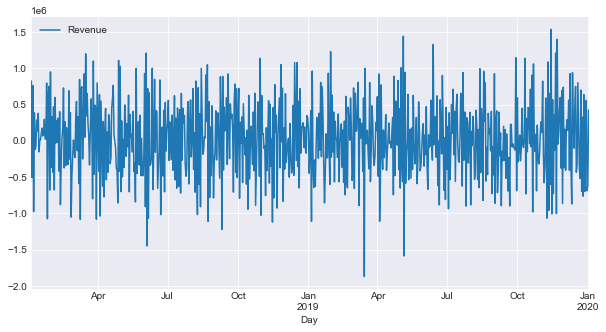

In [5]:
# Plot the Lag-1 difference transformation
diff = df.diff().dropna()
diff.plot(figsize=(10,5))
plt.show()

The lag-1 differencing appears to do the trick and makes the data stationary. Let's confirm that the transformed data is stationary with the Augmented Dickey-Fuller test.

In [6]:
# Run an Augmented Dickey-Fuller Test on the lag-1 differenced data
result = adfuller(diff['Revenue'])

print('Diff 1 Augmented Dickey-Fuller p-value: %.3f'%result[1])

Diff 1 Augmented Dickey-Fuller p-value: 0.000


Performing a lag-1 differnce on the data has successfully transformed the data to be stationary. This difference will be used in the fitting of the ARIMA model later on.

#### 4. Explain the steps used to prepare the data for analysis, including the training and test set split.
After the data was read into the notebook, the column 'Day' was set as the index. I then chose to arbitrarily start the dates on January 3rd, 2018 and converted the index accordingly. I also elected to multiply the 'Revenue' values by 1,000,000 to assist with ease of interpretation. In the cell below I will split the data into a final training and testing set. The test set will consist of the last 30 values of the time series. I did this to align with the research question of projecting revenue for the next month.

In [7]:
# Split and export the time series into training and testing data
split = -30

train = df[:split]
train.to_csv('train_data.csv')
print('Train Set Length: ',len(train))

test = df[split:]
test.to_csv('test_data.csv')
print('Test Set Length: ',len(test))

Train Set Length:  701
Test Set Length:  30


#### Visualize the training and testing data

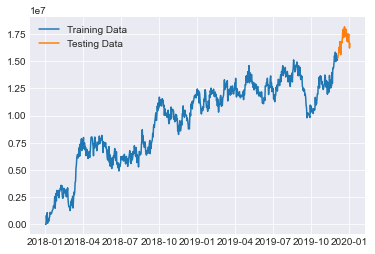

In [8]:
# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.legend()
plt.show()

## Part 4: Model Identification and Analysis
#### 1. Report the annotated findings with visualizations of your data analysis
First, I will assess the seasonality of the data. Based on the plot of the time-series above, there does not appear to be any seasonality in the data. Below is a seasonal decomposition using a period of 30 days as well as a Spectral Density Plot. The 30 day period was chose due to the high volume of month-to-month contracts in the previous data set containing customer information.

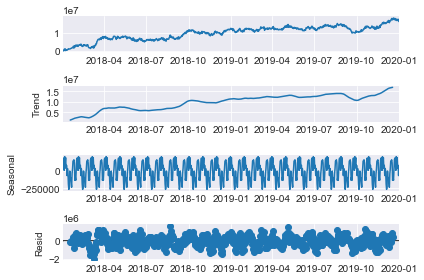

In [9]:
# Create the decomposition object and plot
decomp = seasonal_decompose(df, period=30)
decomp.plot()
plt.show()

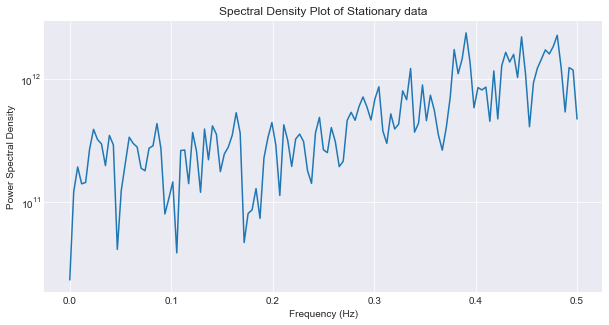

In [10]:
# Calculate and plot the spectral density
f, psd = welch(diff['Revenue'])
plt.figure(figsize=(10,5))
plt.semilogy(f, psd)
plt.title('Spectral Density Plot of Stationary data')
plt.ylabel('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.show()

The decomposition does not confirm whether there is seasonality or not. The residuals seem to slightly follow the same pattern as the trend. On the topic of trend, we can see that the data is trending upwards with a few dips throughout. The Spectral Density also shows no obvious frequency spikes that would relate to a seasonal period. 

Next, we will plot the autocorrelation function and partial autocorrelation function using the lag-1 difference dataframe from above to see if we can identify what orders to use in the ARIMA model later on.

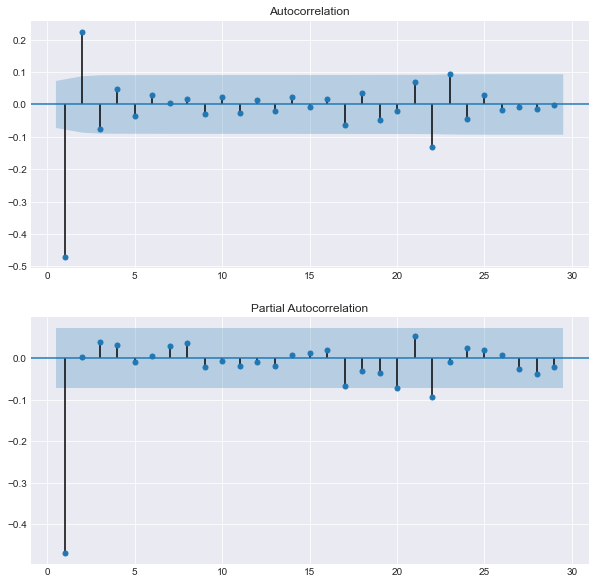

In [11]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
 
# Plot the ACF 
plot_acf(diff, zero=False, ax=ax1)

# Plot the PACF
plot_pacf(diff,zero=False, ax=ax2)

plt.show()

This looks like it could be an AR(1) model. There also appears there may be some seasonality around 22 periods. Let's check this:

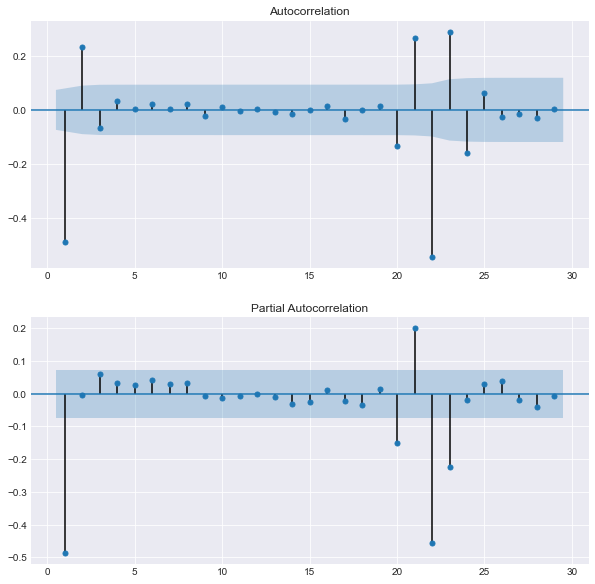

In [12]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
 
# Plot the ACF 
plot_acf(diff.diff(22).dropna(), zero=False, ax=ax1)

# Plot the PACF
plot_pacf(diff.diff(22).dropna(), zero=False, ax=ax2)

plt.show()

The plots above are unclear as to what the best order parameters are to use, but we can see that there is some seasonality at period 22. Below, we will use the auto_arima function from pmdarima to search through and find the best performing orders. 

In [28]:
# Use auto_arima to search for best order parameters
model = auto_arima(train, d=1, max_p=3, max_q=3, # non-seasonal
                   seasonal=True, max_P=3, max_Q=3, m=22, D=0, # seasonal 
                   n_jobs=-1, trace=True, trend='c') # Misc.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[22] intercept   : AIC=20278.353, Time=6.41 sec
 ARIMA(0,1,0)(0,0,0)[22] intercept   : AIC=20454.179, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[22] intercept   : AIC=20271.999, Time=0.95 sec
 ARIMA(0,1,1)(0,0,1)[22] intercept   : AIC=20312.054, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[22]             : AIC=20454.179, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[22] intercept   : AIC=20277.902, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[22] intercept   : AIC=20273.762, Time=3.46 sec
 ARIMA(1,1,0)(1,0,1)[22] intercept   : AIC=20273.826, Time=1.91 sec
 ARIMA(1,1,0)(0,0,1)[22] intercept   : AIC=20271.826, Time=0.88 sec
 ARIMA(1,1,0)(0,0,2)[22] intercept   : AIC=20273.822, Time=2.83 sec
 ARIMA(1,1,0)(1,0,2)[22] intercept   : AIC=20275.814, Time=3.91 sec
 ARIMA(0,1,0)(0,0,1)[22] intercept   : AIC=20445.474, Time=0.71 sec
 ARIMA(2,1,0)(0,0,1)[22] intercept   : AIC=20273.378, Time=1.20 sec
 ARIMA(1,1,1)(0,0,1)[22] intercept   : AIC=20273.451, Time=1.36 sec
 ARIM

#### 2. Identify an autoregressive integrated moving average (ARIMA) model that takes into account the observed trend and seasonality of the time series data.
From the output above we will move forward using an ARIMA(1, 1, 0)(0, 0, 1)[22] Model.

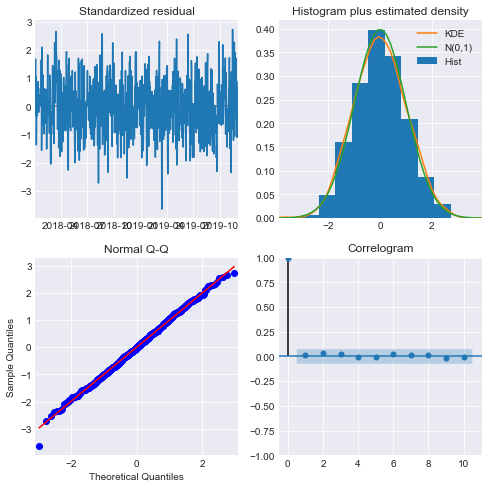

In [14]:
# create the model
model = SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,1,22), trend='c')

# Fit the model and store in results
results = model.fit()

# Use plot_diagnostics to assess the model
results.plot_diagnostics(figsize=(8,8))
plt.show()

The diagnostic plots above look good. Next, we will take a look at the summary of the model

In [15]:
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              Revenue   No. Observations:                  701
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 22)   Log Likelihood              -10131.913
Date:                              Sat, 24 Apr 2021   AIC                          20271.826
Time:                                      09:10:34   BIC                          20290.030
Sample:                                  01-02-2018   HQIC                         20278.863
                                       - 12-03-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.208e+04    1.6e+04      2.003      0.045     696.479    6.35e+04
ar.L1         -0.47

The Prob(Q) and Prob(JB) confirm that our residuals are in line. 

#### 3. Perform a forecast using the derived ARIMA model.
Now that we have identified the model parameters, fit it on the training data, and assessed the residuals created. We are ready to use the model to predict and forecast. First, lets look at how the model does on predicting the final 90 values within the training data it has already seen. We'll only look at the last 180 values of the training data to allow for easier assessment.

##### Predicting on Training Data

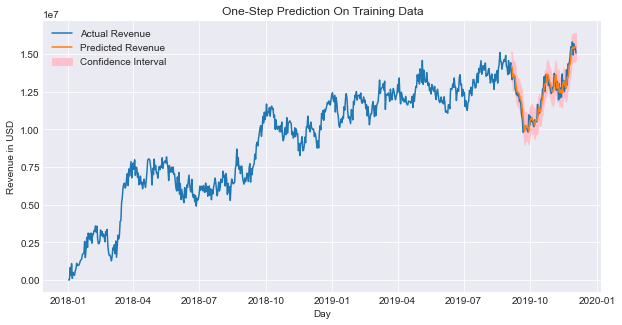

In [16]:
# Predict the last 90 values
predictions = results.get_prediction(start=-90)
# Predict the mean and store
mean_pred = predictions.predicted_mean

# Extract confidence intervals
conf = predictions.conf_int()
# Select lower and upper confidence limits
lower = conf['lower Revenue']
upper = conf['upper Revenue']

# Plot the training data values
plt.figure(figsize=(10,5))
plt.plot(train, label='Actual Revenue')
# Plot the predicted values
plt.plot(mean_pred.index, mean_pred, label='Predicted Revenue')
# Plot the Confidence Interval
plt.fill_between(lower.index, lower, upper, label='Confidence Interval', color='pink')

# Plot Aesthetics
plt.legend()
plt.title('One-Step Prediction On Training Data')
plt.xlabel('Day')
plt.ylabel('Revenue in USD')
plt.show()

The above plot looks like the one-step predictions are very accuracte in relation to the actual values. We will now use the model to forecast 90 days past the training data and compare it to the testing data that was set aside earlier.

##### Forecasting against the testing data

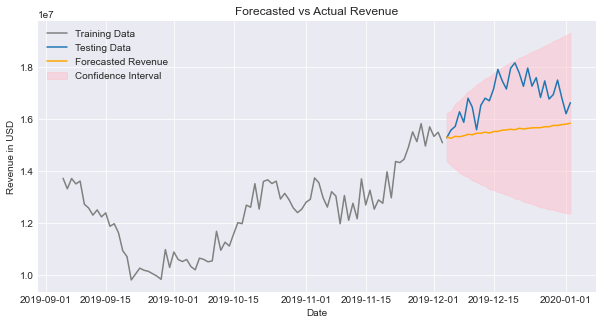

In [38]:
# Forecast the testing data values
forecast = results.get_forecast(steps=-split)
# Predict the mean and store
mean_forecast = forecast.predicted_mean

# Extract confidence intervals
conf = forecast.conf_int()
# Select lower and upper confidence limits
lower = conf['lower Revenue']
upper = conf['upper Revenue']

# Plot the last 90 training data values
plt.figure(figsize=(10,5))
plt.plot(train[-90:], label='Training Data', color='grey')
# Plot the test data values
plt.plot(test.index, test, label='Testing Data')
# Plot the Forecasted values
plt.plot(mean_forecast.index, mean_forecast, label='Forecasted Revenue', color='orange')
# Plot the confidence interval
plt.fill_between(lower.index, lower, upper, label='Confidence Interval', color='pink', alpha=0.5)

# Plot Aesthetics
plt.title('Forecasted vs Actual Revenue')
plt.xlabel('Date')
plt.legend()
plt.ylabel('Revenue in USD')
plt.show()

In [18]:
MSE = mse(test['Revenue'], mean_forecast)
print('Forecast MSE: %.2f'%MSE)

RMSE = np.sqrt(MSE)
print('Forecast RMSE: $%.2f'%RMSE)

Forecast MSE: 2808780870913.11
Forecast RMSE: $1675941.79


## Part V: Data Summary and Implications
Throughout this notebook we have used time series analysis to attempt to forecast the 30-day sales projection of the Telecom Company. The 30 day period was used to help the Telecom company assess where short-term focus should be if a high number of activity and sales is expected. We first had to indentify the time series data using a lag-1 difference transformation. After this, we were able to use ACF, PACF, and auto_arima to identify the best orders to use in the ARIMA model. The model ended up being an ARIMA(1,1,0)(0,0,1)[22]. 

Once the model was created and fit, we looked at the diagnostic plots to assess the residuals. These four plots showed good results for the distribution and lack of correlation for the residuals. We also looked at the Prob(Q) and Prob(JB) scores and concluded that the residuals did not raise cause for concern. Finally, the model was used to forecast out 30-days from the training data. This forecast was plotted and assessed against the test data which the model had not yet seen. Looking at the plot, the model did not predict as closely to the testing values as we would have hoped. However, almost all of the testing data was contained within the confidence intervals of the model except for a few spikes in the middle. This visualization is both above and below for convenience. To quantify the models accuracy we used the root mean squared error which came out to $1,675,941. This is a high number and comes out to be about a 10% error.

While this model does a decent job at forecasting revenue, it could still use some tuning. For the time being, I recommend the Telecom company use this as a first stop analyzer for revenue and incorporate other business projection methods as well in order to accurately allocate their resources. In the future they should continue to develop a more accurate model that will have more reliability going forward to lower the necessity for multiple methods.

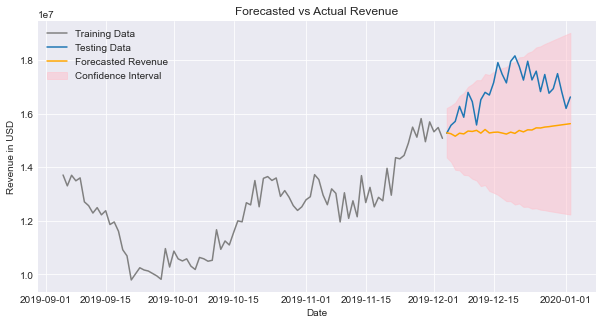

In [19]:
# Plot the last 90 training data values
plt.figure(figsize=(10,5))
plt.plot(train[-90:], label='Training Data', color='grey')
# Plot the test data values
plt.plot(test.index, test, label='Testing Data')
# Plot the Forecasted values
plt.plot(mean_forecast.index, mean_forecast, label='Forecasted Revenue', color='orange')
# Plot the confidence interval
plt.fill_between(lower.index, lower, upper, label='Confidence Interval', color='pink', alpha=0.5)

# Plot Aesthetics
plt.title('Forecasted vs Actual Revenue')
plt.xlabel('Date')
plt.legend()
plt.ylabel('Revenue in USD')
plt.show()

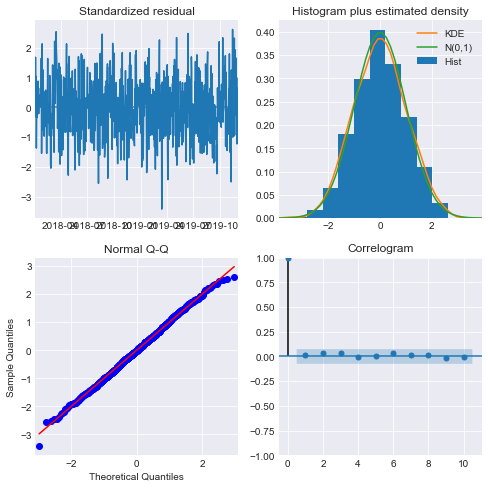

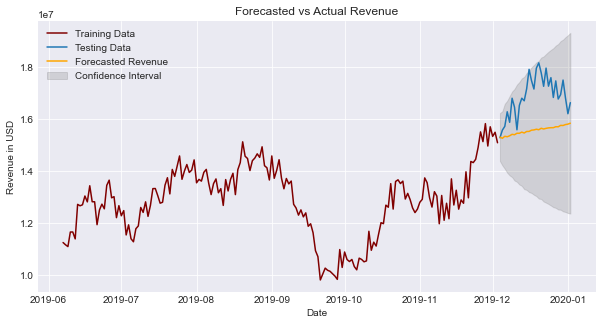

Forecast MSE: 2214414119291.10
Forecast RMSE: $1488090.76


In [39]:
# create the model
model = SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,1,30), trend='c')

# Fit the model and store in results
results = model.fit()

# Use plot_diagnostics to assess the model
results.plot_diagnostics(figsize=(8,8))
plt.show()

# Forecast the testing data values
forecast = results.get_forecast(steps=-split)
# Predict the mean and store
mean_forecast = forecast.predicted_mean

# Extract confidence intervals
conf = forecast.conf_int()
# Select lower and upper confidence limits
lower = conf['lower Revenue']
upper = conf['upper Revenue']

# Plot the last 90 training data values
plt.figure(figsize=(10,5))
plt.plot(train[-180:], label='Training Data', color='maroon')
# Plot the test data values
plt.plot(test.index, test, label='Testing Data')
# Plot the Forecasted values
plt.plot(mean_forecast.index, mean_forecast, label='Forecasted Revenue', color='orange')
# Plot the confidence interval
plt.fill_between(lower.index, lower, upper, label='Confidence Interval', color='grey', alpha=0.25)

# Plot Aesthetics
plt.title('Forecasted vs Actual Revenue')
plt.xlabel('Date')
plt.legend()
plt.ylabel('Revenue in USD')
plt.show()

MSE = mse(test['Revenue'], mean_forecast)
print('Forecast MSE: %.2f'%MSE)

RMSE = np.sqrt(MSE)
print('Forecast RMSE: $%.2f'%RMSE)